In [1]:
using NBInclude
@nbinclude("functions.ipynb")


All function imported


In [2]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function load_model_sep(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

# pick a image in MNIST to denoise
num = 6
batch_size = 64
shuffle_data = true
dataloader = get_test_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];

┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195


In [3]:
#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 5000; out_toggle = 0
trials = 2
opt = Flux.Optimise.ADAM(.1);
# z = randn(k) 

# encoder_μ_inco, encoder_logvar_inco,  W1_inco, W2_inco, W3_inco, Q_inco = load_model_sep("trained_GNN/MNIST_identity_v4", 40)
# μ = encoder_μ_inco(x_true)
# logvar_inco = encoder_logvar_inco(x_true)

# Apply reparameterisation trick to sample latent
# z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco) # ground code vector



B = randn(x_dim, 500)/sqrt(x_dim)
F = dct(diagm(ones(x_dim)),2);

_, _,  W1_co, W2_co, W3_co, Q_co = load_model_sep("trained_GNN/MNIST_v2", 40)

β_list, α_list = get_β_α(F, Q_co, B, 11);




# subspace_incoherence(F,decoder_last)



Loading model...Done

2×12 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [6]:
trials = 5
recovery_error_matrix = zeros(trials, 1 + length(β_list) )
recon_error_matrix = zeros(trials, 1 + length(β_list) );

In [7]:
# z = z_inco # ground code vector
z=randn(20)
println(norm(z))
m = 300



Threads.@threads for i in 1:length(β_list)
    recovery_error_list = []
    recon_error_list = []
    β = β_list[i]
    G = Chain(
        Dense(20, 500, relu, bias = false; init =(out,in) ->  W1_co),
        Dense(500, 500, relu, bias = false; init =(out,in) -> W2_co),
        Dense(500, 784, identity, bias = false; init =(out,in) -> β * Q_co + (1-β)*B),
    )   #setup the generative network 


    # G = Chain(
    #     Dense(20, 500, relu, bias = false; init =(out,in) ->  W1_inco),
    #     Dense(500, 500, relu, bias = false; init =(out,in) -> W2_inco),
    #     Dense(500, 784, identity, bias = false; init =(out,in) -> β * Q_co + (1-β)*Q_inco*W3_inco),
    # )   #setup the generative network 

    
    for trials in 1:trials
        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
        y = F_sub * G(z) # measurement vector using subsampled DCT matrix
  
        z_est = randn(k) #initialization for algorithm
        z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

        push!(recovery_error_list, relative_error(z, z_est))    
        push!(recon_error_list, relative_error(G(z), G(z_est)))
    end

    recovery_error_matrix[:, i + 1] =  recovery_error_list
    recon_error_matrix[:, i + 1] = recon_error_list
end

5.1440865067113055


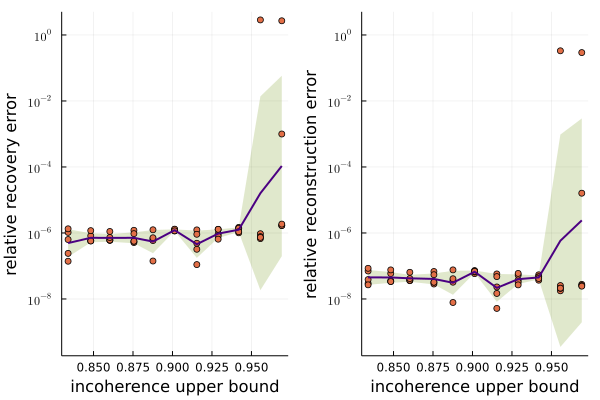

In [8]:
log_recovery_error_matrix = log10.(recovery_error_matrix[:, 2:end])
average_recov = mean(log_recovery_error_matrix, dims=1)'
std_recov = std(log_recovery_error_matrix, dims=1)'
plot(α_list, average_recov + std_recov, fillrange =  average_recov - std_recov, fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
scatter!(kron(α_list',ones(trials,1))[:], log_recovery_error_matrix[:], label =:false)
p1 = plot!(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false)
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])



log_recon_error_matrix = log10.(recon_error_matrix[:, 2:end])
average_recon = mean(log_recon_error_matrix, dims=1)'
std_recon = std(log_recon_error_matrix, dims=1)'
plot(α_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
scatter!(kron(α_list',ones(trials,1))[:], log_recon_error_matrix[:], label =:false)
p2 = plot!(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false )
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])


plot(p1,p2,layout = 2, ylims = (minimum([ylims(p1)[1],ylims(p2)[1]]), maximum([ylims(p1)[2],ylims(p2)[2]]) ))



In [26]:
std_recov = std(log_recovery_error_matrix, dims=1)'

11×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.09556447753539932
 0.12325806107329887
 0.11215058855713685
 0.5279793543846237
 0.6592537528696912
 0.3917245333942104
 1.4553187359558384
 0.9945775941949647
 1.5945384244380367
 1.5720202026019117
 1.0003929711835662

In [25]:

savefig("figures/Full_MNIST_incoherent_error.pdf")
save("saved_data/Full_incoherent_MNIST_error.jld", "recovery error", recovery_error_matrix, "reconstruction error", recon_error_matrix, "α_list", α_list)

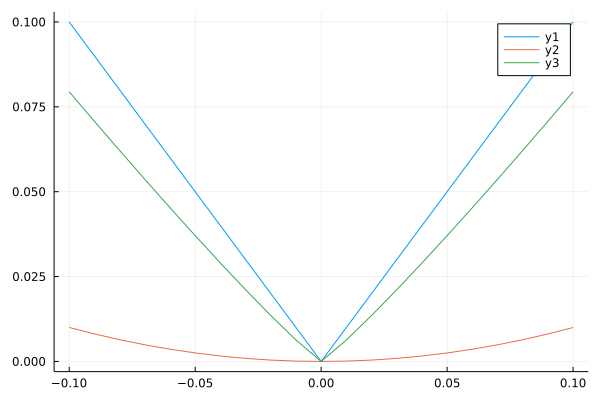

In [14]:
using Plots
x=-.1:.01:.1
# plot(x,@.(exp(x^2)))
plot(x,@.(abs(x)))
plot!(x,@.(x^2))
plot!(x,@.(abs(x)^1.1))

In [1]:
.8*(100)^(1/100)
using Flux
using Plots

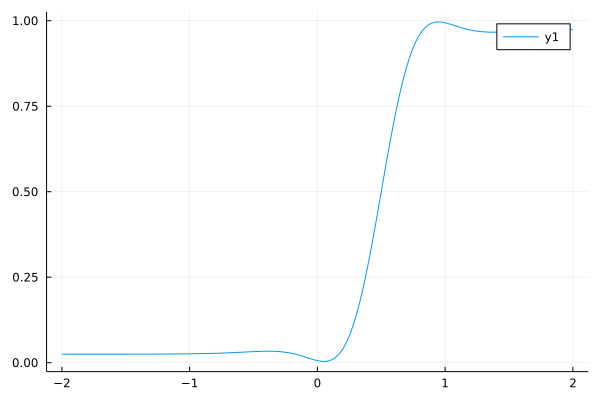

In [50]:
x = -2:.01:2
function sig_shifted(x)
    M = 1.04187855854289
    X = 1.01570942991227
    α = X/0.45
    sig(x) = (exp(-x^2)+.99) * tanh(x)
    return @.(sig(α*(x-.5))/(2M)  + 1/2)
end

function sig_shifted_v2(x)
    M = 0.375261028309015
    X = 0.624697168346519
    α = X/0.25
    sig(x) = exp(-x^2)*tanh(x)
    return @.(sig(α*(x-.5))/(2M)  + 1/2)
end

function sig_shifted_v3(x)
    M = 0.321140015957206
    X = 0.58703932739034
    α = X/0.5
    sig(x) = (exp(-x^2) - .1)*tanh(x)
    return @.(sig(α*(x-.5))/(2M)  + 1/2)
end

using Plots

plot(x,@.(sig_shifted(x)))

# plot!(x,@.(abs(x)^1.1))

In [18]:
maximum(randn(4,4))

2.703378770750239

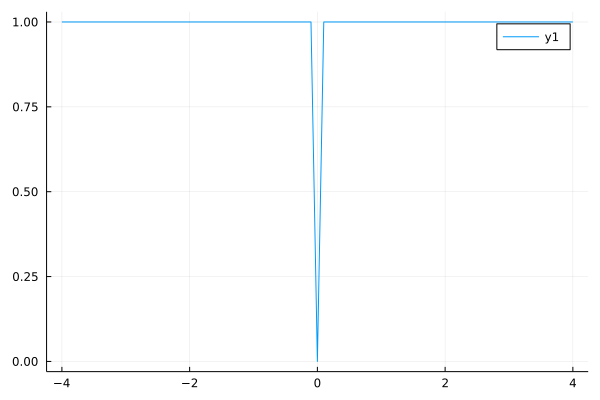

In [4]:
x = -4:.1:4

sig_2(x) =  (exp(-100x^2)+1) * tanh(x)
plot(x, @.(-exp(-(100x)^2) +1))

0.624697168346519

In [40]:
2M

0.7506